# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
import scipy.io
import tarfile
import csv
from sklearn.model_selection import train_test_split

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

In [3]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [4]:
print(os.listdir("/data1/datasets/flowers"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['imagelabels.mat', '102flowers.tgz']
Python       : 3.9.12 (main, Jun  1 2022, 11:38:51) 
Numpy        : 1.22.3
Tensorflow   : 2.9.1
Keras        : 2.9.0


In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Setup

In [7]:
EPOCHS               = 50
BATCH_SIZE           = 64 # 128
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 128
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/data1/datasets/flowers/'
PATH = DATA_PATH + "work/"

In [8]:
os.makedirs(PATH,exist_ok=False)

In [9]:
# Setting seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [10]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [11]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [12]:
df['Category'].value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: Category, Length: 102, dtype: int64

In [13]:
df['Category'].nunique()

102

In [14]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)
print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_01453.jpg', 'image_02490.jpg', 'image_05444.jpg', 'image_00272.jpg', 'image_01171.jpg']


Пример картинок (random sample)


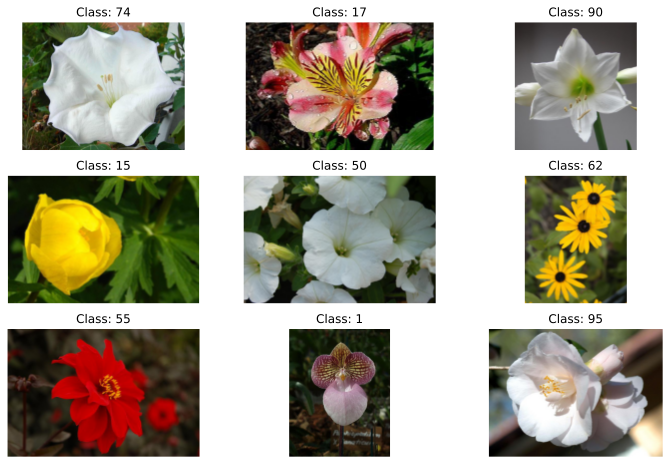

In [15]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


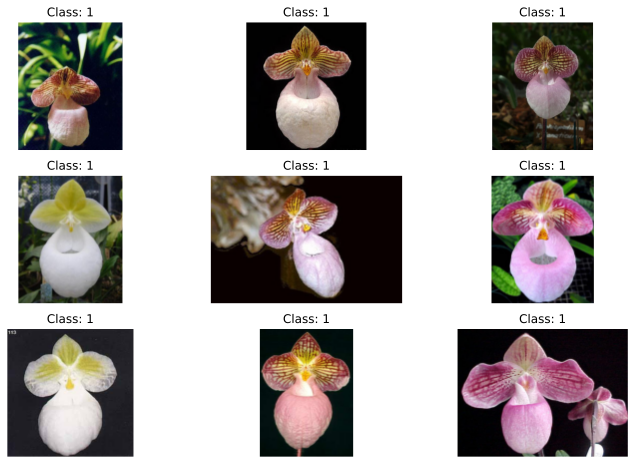

In [16]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

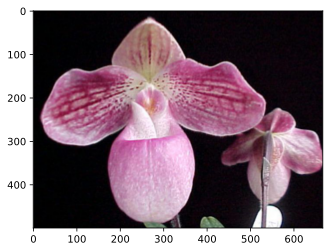

(667, 500)

In [17]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [18]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=RANDOM_SEED, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [19]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [20]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
0      32
6      32
33     32
2      32
26     32
Name: Category, Length: 102, dtype: int64

In [21]:
test_files['Category'].value_counts()

50    52
76    50
72    39
45    39
88    37
      ..
78     8
0      8
20     8
24     8
66     8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [22]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [23]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [24]:
from skimage import io

In [25]:
def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

Пример картинок из train_generator


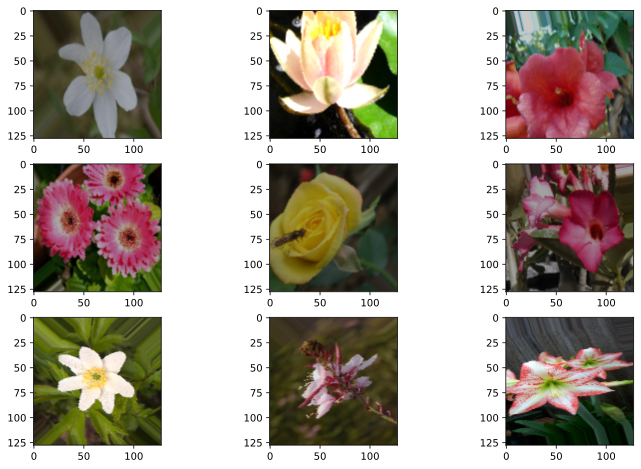

In [92]:
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


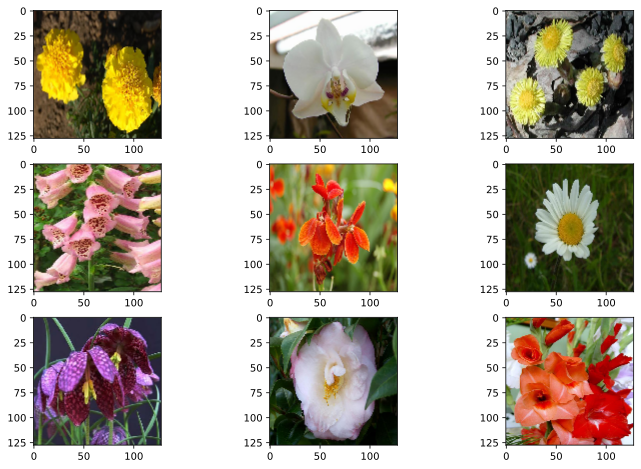

In [26]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [27]:
input_shape

(128, 128, 3)

In [28]:
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Jul 26 18:33:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   46C    P2   118W / 350W |   1150MiB / 12288MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [29]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

In [30]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [31]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [32]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [34]:
# сколько слоев
print(len(model.layers))

3


In [35]:
len(model.trainable_variables)

2

In [36]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7fe34b9a6310> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe34bb05700> True
<keras.layers.core.dense.Dense object at 0x7fe3d8364190> True


## Fit

In [37]:
MODEL_PATH = DATA_PATH + "model/"
os.makedirs(MODEL_PATH, exist_ok=False)

In [38]:
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_model.hdf5', monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [39]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [40]:
scores = model.evaluate(test_generator, steps=1, verbose=1) # model.evaluate_generator
print("Accuracy: %.2f%%" % (scores[1]*100))

2022-07-26 18:33:56.952315: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-26 18:33:56.952793: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step - loss: 5.7346 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [41]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 2.7550 - accuracy: 0.3678
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 36s 343ms/step - loss: 2.7550 - accuracy: 0.3678 - val_loss: 1.5310 - val_accuracy: 0.6031
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.6437
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 35s 346ms/step - loss: 1.3890 - accuracy: 0.6437 - val_loss: 1.1519 - val_accuracy: 0.7044
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 1.0894 - accuracy: 0.7122
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 35s 343ms/step - loss: 1.0894 - accuracy: 0.7122 - val_loss: 1.0146 - val_accuracy: 0.7412
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.7407
E

In [53]:
# K.clear_session()

In [42]:
model.save(MODEL_PATH + 'model_step1.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [43]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 232ms/step - loss: 0.7028 - accuracy: 0.8125
Accuracy: 81.25%


In [48]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

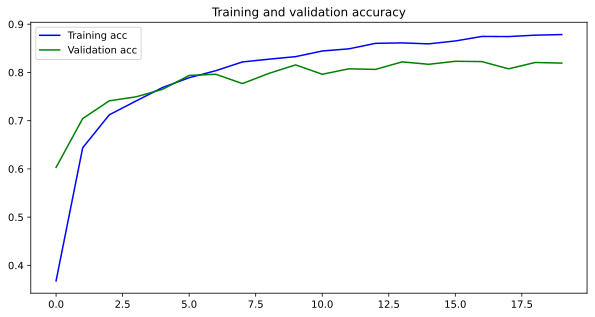

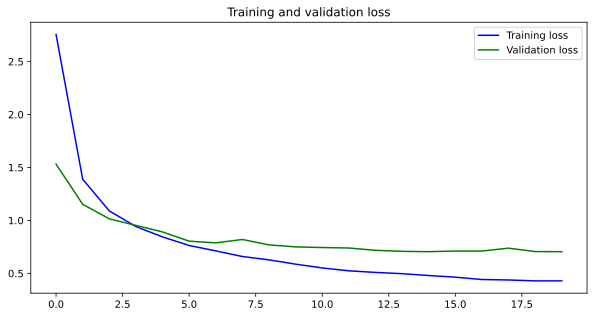

In [49]:
plot_history(history)

## Step 2

In [50]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [51]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [52]:
len(base_model.trainable_variables)

82

In [53]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7fe34b9a6310> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe34bb05700> True
<keras.layers.core.dense.Dense object at 0x7fe3d8364190> True


In [54]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,773,798
Trainable params: 20,768,870
Non-trainable params: 3,004,928
_________________________________________________________________


In [56]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 933ms/step - loss: 0.7028 - accuracy: 0.8125
Accuracy: 81.25%


In [57]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 1.0755 - accuracy: 0.7157
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 38s 350ms/step - loss: 1.0755 - accuracy: 0.7157 - val_loss: 0.9430 - val_accuracy: 0.7544
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8747
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 36s 349ms/step - loss: 0.4490 - accuracy: 0.8747 - val_loss: 0.4920 - val_accuracy: 0.8644
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9155
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 36s 349ms/step - loss: 0.2971 - accuracy: 0.9155 - val_loss: 0.4596 - val_accuracy: 0.8706
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9271
E

In [69]:
model.save(MODEL_PATH + 'model_step2.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [70]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 211ms/step - loss: 0.3056 - accuracy: 0.9219
Accuracy: 92.19%


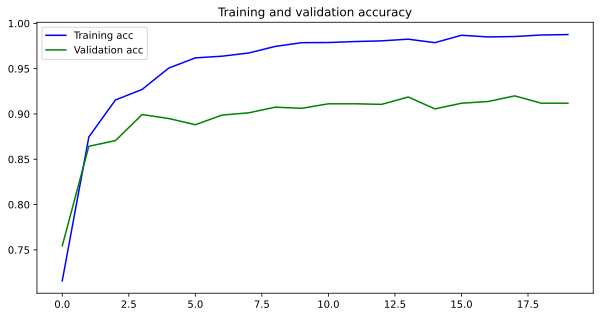

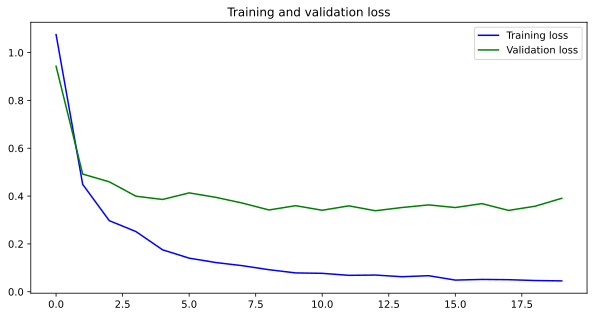

In [71]:
plot_history(history)

## step 3

In [72]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

len(base_model.trainable_variables)

128

In [73]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,773,798
Trainable params: 23,190,118
Non-trainable params: 583,680
_________________________________________________________________


In [75]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 908ms/step - loss: 0.3056 - accuracy: 0.9219
Accuracy: 92.19%


In [76]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9783
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 39s 359ms/step - loss: 0.0687 - accuracy: 0.9783 - val_loss: 0.4707 - val_accuracy: 0.8963
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9743
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 37s 358ms/step - loss: 0.0789 - accuracy: 0.9743 - val_loss: 0.5153 - val_accuracy: 0.8844
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9781
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 37s 361ms/step - loss: 0.0725 - accuracy: 0.9781 - val_loss: 0.4378 - val_accuracy: 0.8963
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9830
E

In [77]:
model.save(MODEL_PATH + 'model_step3.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [79]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 200ms/step - loss: 0.3652 - accuracy: 0.8906
Accuracy: 89.06%


In [ ]:
plot_history(history)

## Step 4

In [80]:
base_model.trainable = True
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [81]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 895ms/step - loss: 0.3652 - accuracy: 0.8906
Accuracy: 89.06%


In [82]:
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9847
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 37s 341ms/step - loss: 0.0482 - accuracy: 0.9847 - val_loss: 0.4165 - val_accuracy: 0.9081
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9884
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 34s 335ms/step - loss: 0.0346 - accuracy: 0.9884 - val_loss: 0.3600 - val_accuracy: 0.9169
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9914
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 35s 339ms/step - loss: 0.0285 - accuracy: 0.9914 - val_loss: 0.3391 - val_accuracy: 0.9169
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9937
E

In [83]:
model.save(MODEL_PATH + 'model_step4.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [84]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 211ms/step - loss: 0.2798 - accuracy: 0.9219
Accuracy: 92.19%


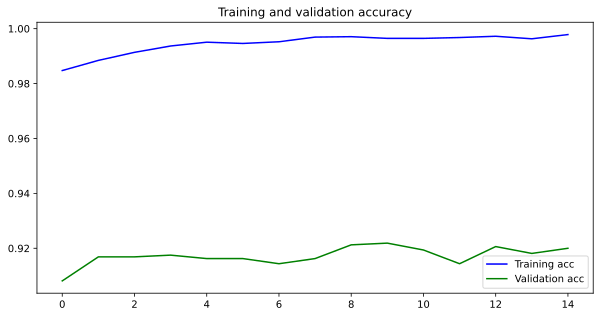

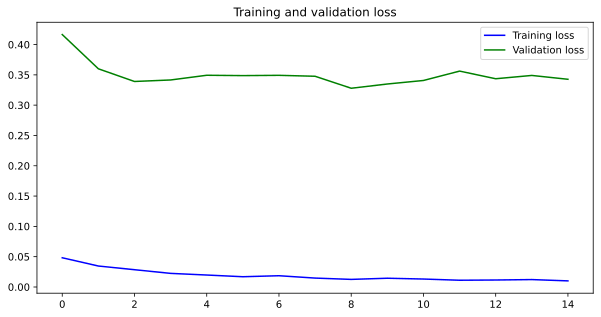

In [85]:
plot_history(history)

## отжиг LR

In [86]:
LR=0.001 # поднимаем LR
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [87]:
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 1.1866 - accuracy: 0.6781
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 38s 344ms/step - loss: 1.1866 - accuracy: 0.6781 - val_loss: 8.9160 - val_accuracy: 0.1825
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.7715
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 34s 334ms/step - loss: 0.8048 - accuracy: 0.7715 - val_loss: 2.7983 - val_accuracy: 0.4769
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.8206
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 34s 332ms/step - loss: 0.6197 - accuracy: 0.8206 - val_loss: 3.4494 - val_accuracy: 0.3744
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.8514
E

In [88]:
model.save(MODEL_PATH + 'model_burn_lr.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [89]:
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 198ms/step - loss: 0.7883 - accuracy: 0.8281
Accuracy: 82.81%


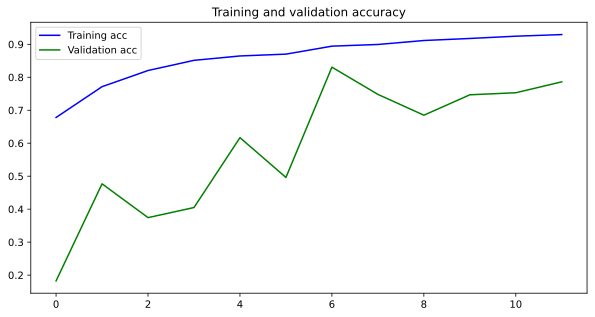

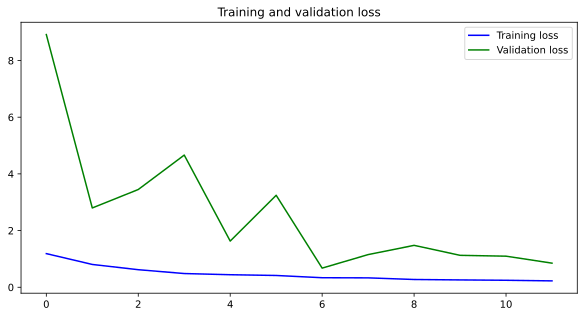

In [90]:
plot_history(history)

In [91]:
# Clean PATH
import shutil
shutil.rmtree(PATH)
shutil.rmtree(MODEL_PATH)